### A RNN model for Representational Drift Driven Through Intrinsic Exctitability and Synaptic Volatility

#### Import

In [32]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import statistics
import itertools 
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from dataclasses import dataclass
np.random.seed(0) 
plt.style.use('../style_sheet.mplstyle')
print("Libraries loaded successfully.")

Libraries loaded successfully.


# Setup

### Model Parameter

In [38]:

#Network parameters
N = 50 # Number of neurons

#Inhibition parameters
I0 = 5
I1 = 1
I2 = .05

#Time constants
taur = 50 #firing rate decay
tauw = 1000 #synaptic weight learning rate
tautheta = 800 # threshold adaptation rate
decay = 1000 #weight decay time constant

#Initial conditions
y0 = 10 
r0 = np.zeros(N) #initial firing rates
w0 = np.zeros(N * N) # initial weights
theta0 = np.zeros(N) # initial thresholds

#Simulation parameters
nstep = 13000 #Total number of time steps
dt = 1 # time step size

#Stimulus parameters
IN = 15 # input amplitude
Nstim = 10 # number of stimulation pulses per day
stim = 200 # duration of each stimulation pulse (includes the gap imediately after)
duration = 100 # duration of gap between stimulation pulses (so increasing this shortens the actual pulse duration) [default 100ms]
pause = 1000 # duration of pause before stimulation starts
delay = 3000 # delay between day starts (so the actual gap is delay - (Nstim * stim) [default 1000ms])
Nevent = 4 # number of stimulation days 

#Excitability parameters
E = 1.5 # elevated excitability factor
E_neuronN_devisions = 5 # number of neuron groups with different excitability
E_time_devisions = 4 # number of time periods with different excitability
E_sigma = 1 # std dev of excitability baseline distribution

#Volatility parameters
vol_mean = 0 # mean of volatility noise
vol_std = 0.02 # standard deviation of volatility noise

#Experiment parameters
Nseed = 1 # number of different random seeds for simulations

print("Parameters set successfully.")


Parameters set successfully.


### Input Sequence

#### Generate Input Sequence

The input array, $seq[ ]$, consists of two times for each pulse, start time and a end time.

In [ ]:
#Constructing the stimulus sequence
seq = []
for ev in range(Nevent):
    for i in range(Nstim):
        # Adding print statements for debugging
        # print(ev, i)
        # print(pause,' + ', i*stim, ' + ', delay*ev)
        # print(pause + i*stim + delay*ev)
        # print(pause,' + ', i*stim,' + ', duration, ' + ', delay*ev)
        # print(pause + i*stim + duration + delay*ev)
        # print("==================")
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1
    
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]

day_timesteps = []
day_timesteps.append(0)
for ev in range(Nevent):
        #day_timesteps.append(int(pause + delay*(ev+0.5)+Nstim*stim*0.5)) # the explanation for this is pretty complicated but drawn out in my notes
        day_timesteps.append(int((pause + delay*ev + Nstim*stim)))
print(day_timesteps)

[0, 3000, 6000, 9000, 12000]


#### Visualise Input Sequence

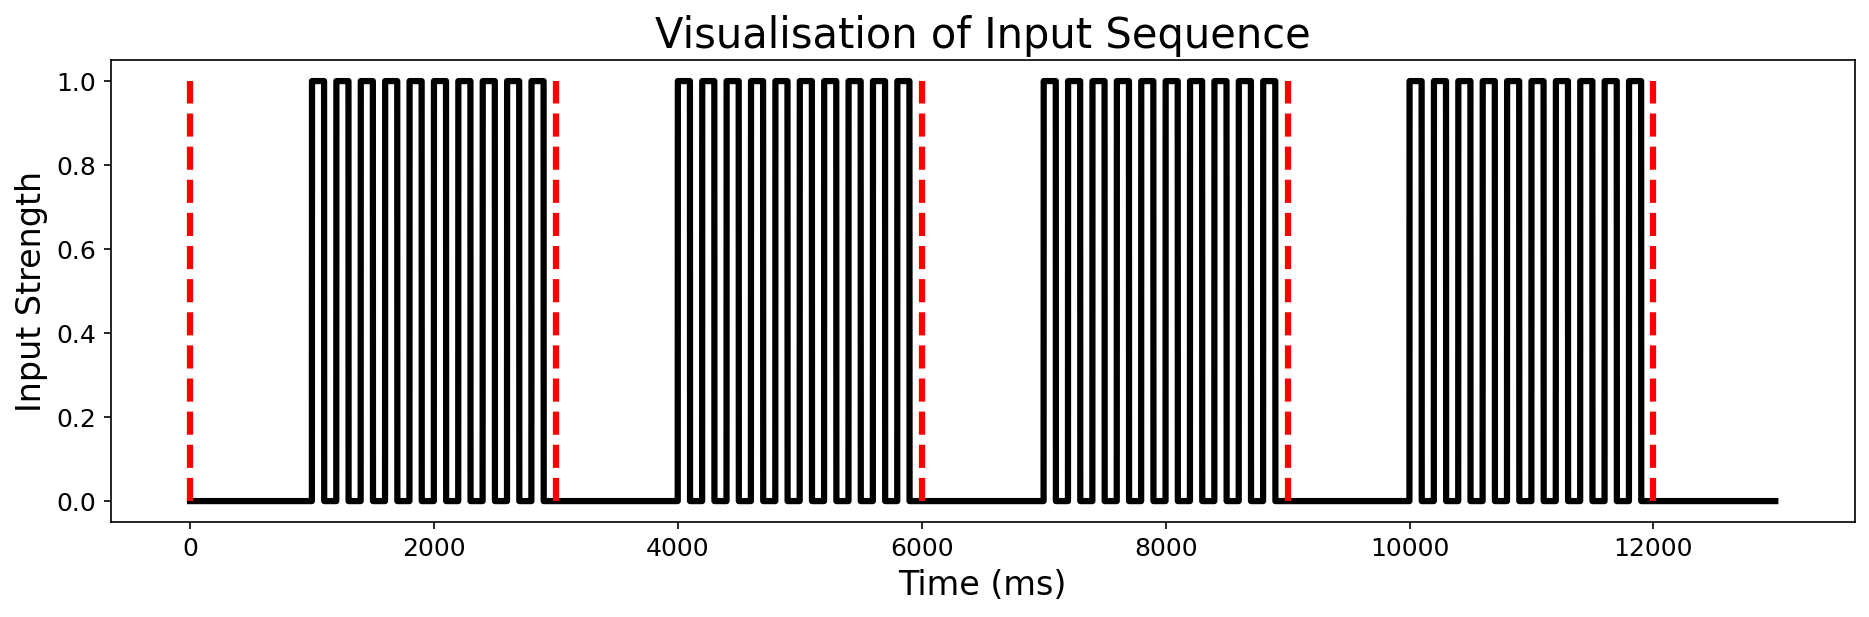

In [5]:
%matplotlib inline

#Visualising the input sequence
time_points = np.arange(0, nstep, 1)
tmp_sig = np.zeros(nstep)
for i in range(len(seq)-1):
    if i % 2 == 0:
        tmp_sig[seq[i]:seq[i+1]] = 1
plt.figure(figsize=(15, 4))
plt.plot(time_points, tmp_sig, color='black')
plt.vlines(day_timesteps, ymin=0, ymax=1, color='red', linestyle='--', label='Day Boundaries')
plt.title("Visualisation of Input Sequence")
plt.xlabel("Time (ms)")
plt.ylabel("Input Strength")
plt.show()

### Excitability Fluctuations

#### Generate Excitability Function

In [89]:
def create_emat():  
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,E_sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    Emat = np.zeros((N,nstep))
    for i in range(E_neuronN_devisions):
        for j in range(E_time_devisions):
            if i == j+1:
                #print("N: ", i*int(N/E_neuronN_devisions), " to ", (i+1)*int(N/E_neuronN_devisions), " Time: ", j*int(nstep/E_time_devisions), " to ", (j+1)*int(nstep/E_time_devisions))
                Emat[i*int(N/E_neuronN_devisions):(i+1)*int(N/E_neuronN_devisions), j*int(nstep/E_time_devisions):(j+1)*int(nstep/E_time_devisions)] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return Emat

#### Visualise Excitability

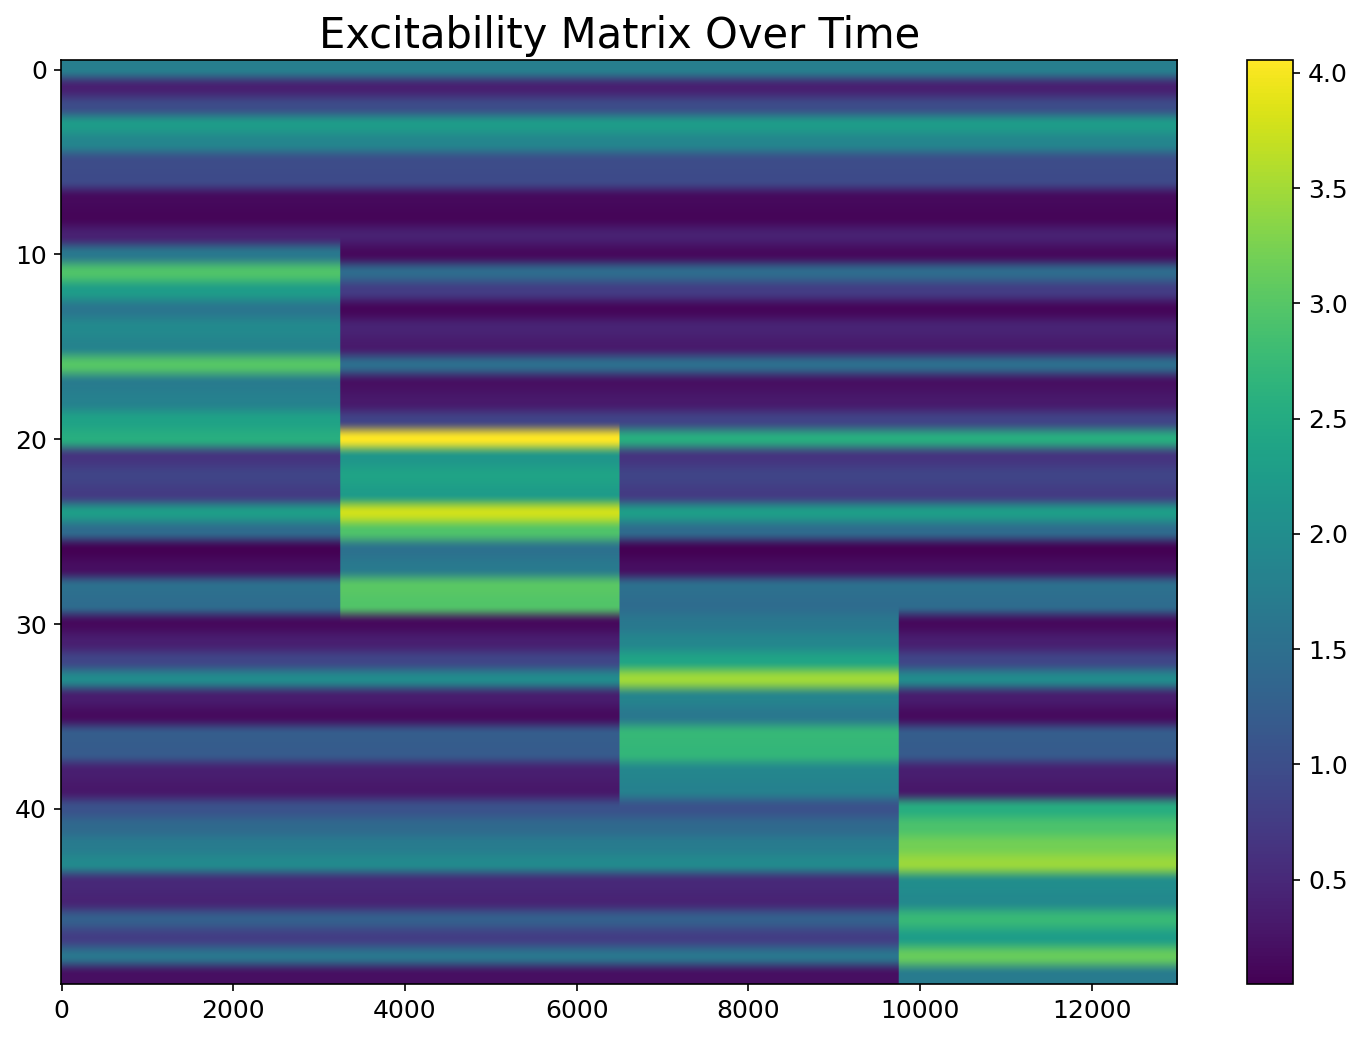

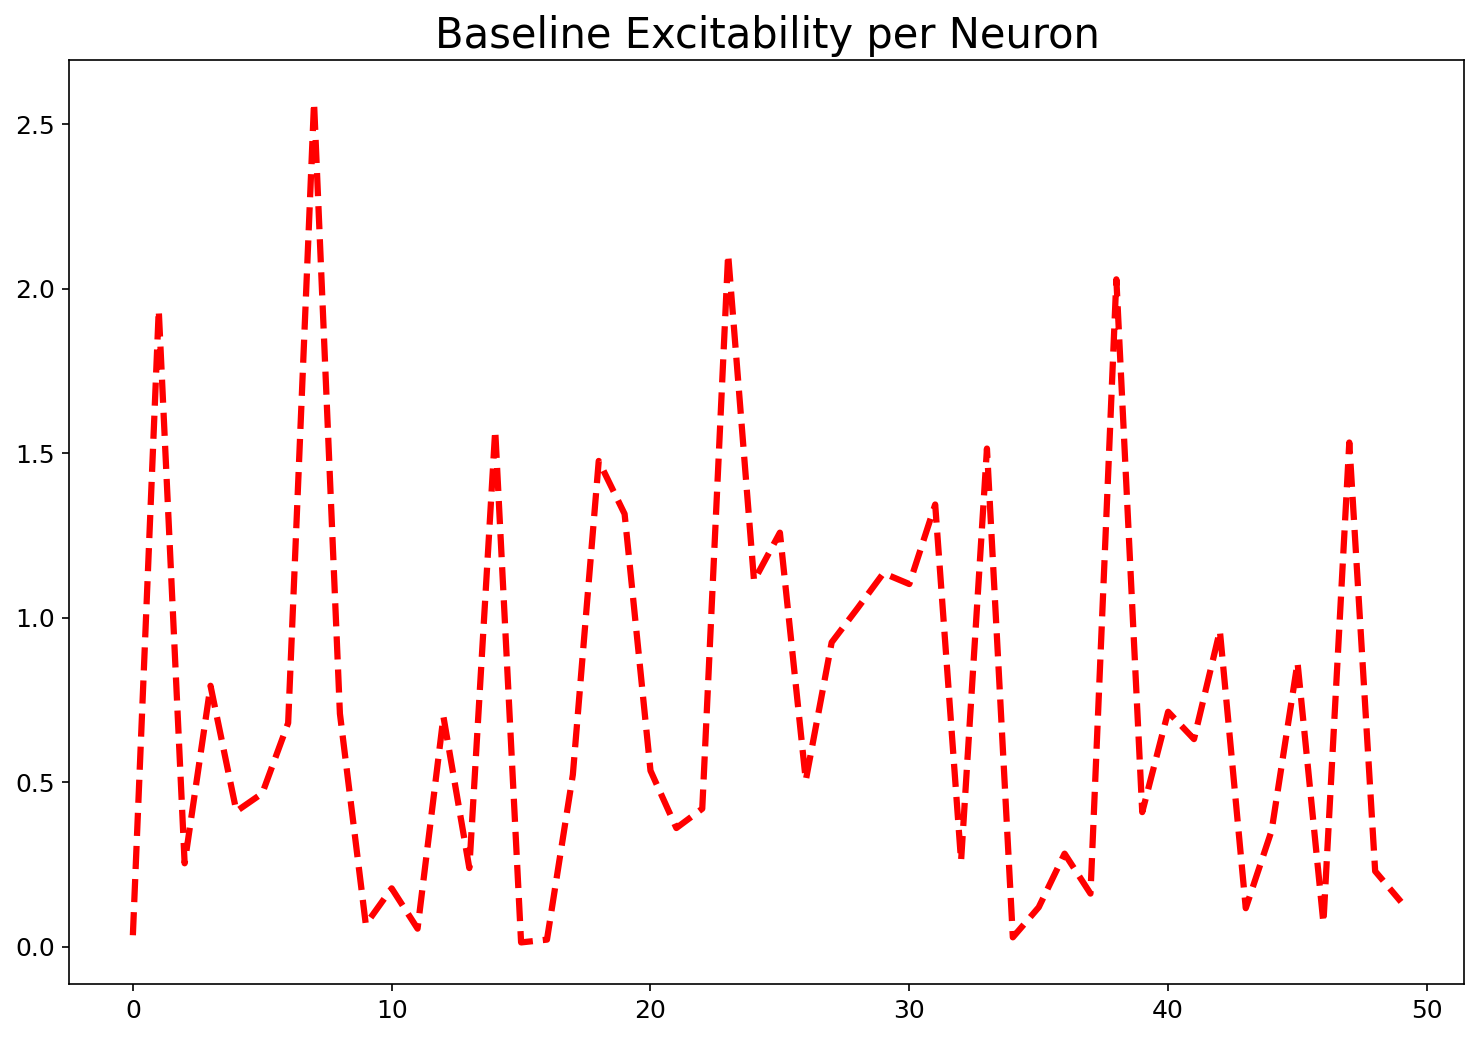

In [88]:
%matplotlib inline

#Parameters for excitability matrix
sigma = 1
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)



plt.figure()
plt.imshow(Emat, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Excitability Matrix Over Time')
plt.show()
plt.plot(exc0, 'r--', label='Baseline Excitability')
plt.title('Baseline Excitability per Neuron')
plt.show()

# Main Loop

### Update Function

Implement the main update function across the network.
<br>
Spike Updates <br>
Inhibition current (Eq. 1):
$$
r_{inhib} = I_0 + I_1 \cdot \sum_{i = 0}{r_i} + I_2 \cdot \sum_{i = 0}{r_i^2}
$$
Firing rate equation (Eq. 2): 
$$
\frac{dr}{dt} = (-r + \phi[w \cdot r + I_{ext}(t) - I_{inhib} + E(t)])
$$

Theta Updates <br>
Theta equation (Eq. 3):
$$
\frac{d\theta}{dt} = \frac{\frac{r}{y_0} - \theta}{\tau_\theta}
$$

Weight Updates <br>
Weight Equation (Eq. 4):
$$
\frac{dw}{dt} = \frac{ \sum{r_i \times r_j}}{\tau_w} - \frac{w}{decay} + \sigma
$$
(clamped between 1 and 0)

Excitability Updates <br>
Excitability Equation (Eq. 4):
$$
\frac{dE}{dt} = 0
$$
(follows Emat not time evolution)

In [8]:
def f(yt,t,tag,dt):
    # define values
    global theta
    r = yt[index[0]][np.newaxis].T # Index 0: firing rates
    r = r*(r>1e-5) # say its zero if its very small

    W = yt[index[1]].reshape((N,N)) # Index 1: synaptic weights

    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T # Index 3: thresholds

    #inhibition equation (Eq. 1)
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*I2

    #firing rate evolution (Eq. 2)
    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    #theta evolution (Eq. 3)
    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta

    #weight evolution (Eq. 4)
    dWdt = r.dot(r.T) / tauw - W/decay + np.random.normal(vol_mean,vol_std,(N,N))
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))

    #excitation evolution
    dexcdt = np.zeros(N)
    #this is essentially dead code as it follows emat instead of a differential evolution
    
    #reshape y
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

### Run Function

Update the state matrix paramters according to the Euler Method:
$$\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot f(\mathbf{y}_n, t_n, \text{tag}, \Delta t)$$

$\mathbf{y}_{n+1}$ => New state matrix at $t + 1$ <br>
$\mathbf{y}_n$ => Current state matrix at $t$ <br>
$\Delta t$ => Timescale of each system update <br>
$t_n$ => Current timestep of the model <br>
$tag$ => Currently redundant <br>


In [9]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    tag = 0
    thetaL = np.zeros((N,1))
    y0 = np.concatenate((r0,w0,exc0,theta0))
    y = np.zeros((len(y0), nstep)) #y is a complete description of the enviroment of all time
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y

# Decoder Functions

## Helper Functions

$r = \frac{\sum_{i=1}^{n} (V_i - \bar{V_i})(V_j - \bar{V_j})}{\sqrt{\sum_{i=1}^{n} (V_i - \bar{V_i})^2} \sqrt{\sum_{i=1}^{n} (V_j - \bar{V_j})^2}}$


In [71]:
def correlation(v1, v2):
    """Calculates Pearson correlation between two vectors."""
    # Centering the vectors (subtract mean)
    v1_c = v1 - np.mean(v1)
    v2_c = v2 - np.mean(v2)
    
    numerator = np.sum(v1_c * v2_c)
    denominator = np.sqrt(np.sum(v1_c**2) * np.sum(v2_c**2))
    
    # Handle zero division if vectors are constant
    if denominator == 0:
        return 0.0
    return numerator / denominator

## Day Decoder

This is still a bit incomplete but getting there.

In [ ]:
def day_decoder(V_list):
    decod = np.zeros((Nseed, Nevent))
    for seed in range(Nseed):
        for day in range(Nevent):
            corr = []
            for day_try in range(Nevent):
                corr.append(correlation(V_list[seed,0,day,:],V_list[seed,1,day_try,:]))

            decod[seed,day] = np.where(corr == np.max(corr))[0]
    
    
    V_list_shuffled = np.copy(V_list)
    decod_shuffled = np.zeros((Nseed,4))
    for seed in range(Nseed):
        V = np.copy(V_list_shuffled[seed,1,:,:])
        np.random.shuffle(V)
        V_list_shuffled[seed,1,:,:] = V
        
        for day in range(Nevent):
            corr = []
            for day_try in range(Nevent):
                corr.append(correlation(V_list_shuffled[seed,1,day,:],V_list_shuffled[seed,0,day_try,:]))
            #print(corr)
            decod_shuffled[seed,day] = np.where(corr == np.max(corr))[0]

    return decod, decod_shuffled

## Ordinal Time Decoder

Test whether the drift is gradual. It does this by attempting to place the end of day firing rates in order depending on their correlations. As drift is by definition sequential this is a helpful metric for evaluating paramter suitability.

In [104]:
def pearson_corr(a: np.ndarray, b: np.ndarray) -> float:
    """Pearson correlation, matching your manual implementation."""
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = np.sqrt(np.sum(a0 * a0) * np.sum(b0 * b0))
    return float(np.sum(a0 * b0) / denom) if denom > 0 else 0.0


def otd_get_sequence_score(activity_matrix, day_order, correlation_fn, normalise=True):
    """
    Sum of correlations between adjacent days in a proposed order.
    activity_matrix: (N_days, N_neurons)
    day_order: tuple like (0,1,2,3)
    normalise: if True, divide by (N_days-1) to match paper's axis scale (~0..0.8)
    """
    score = 0.0
    for i in range(len(day_order) - 1):
        a = activity_matrix[day_order[i], :]
        b = activity_matrix[day_order[i + 1], :]
        score += correlation_fn(a, b)

    if normalise and len(day_order) > 1:
        score /= (len(day_order) - 1)

    return score


def make_neuronwise_shuffled_V_list(V_list, rng=None):
    """
    Paper-style shuffle:
    For each seed and each neuron, shuffle the day labels independently.

    V_list: (N_days, N_neurons, N_seeds)
    Returns V_shuf with same shape.
    """
    if rng is None:
        rng = np.random.default_rng()

    N_days, N_neurons, N_seeds = V_list.shape
    V_shuf = np.empty_like(V_list)

    for seed in range(N_seeds):
        # For each neuron, permute its day-values independently
        for n in range(N_neurons):
            perm = rng.permutation(N_days)
            V_shuf[:, n, seed] = V_list[perm, n, seed]

    return V_shuf


def ordinal_time_decoder(V_list, correlation_fn, permutations=None, normalise=True):
    """
    Ordinal time decoder (paper-equivalent).

    V_list: (N_days, N_neurons, N_seeds)
    Returns:
      - scores_all: (N_seeds, N_perms)
      - true_scores: (N_seeds,)
      - best_scores: (N_seeds,)
      - best_perms: (N_seeds, N_days)
      - t_values: (N_seeds,)   where t is a z-score within seed over permutations
    """
    N_days = V_list.shape[0]
    N_seeds = V_list.shape[2]

    if permutations is None:
        permutations = list(itertools.permutations(range(N_days)))

    # ensure true permutation index
    true_perm = tuple(range(N_days))
    try:
        true_idx = permutations.index(true_perm)
    except ValueError:
        raise ValueError("True permutation (0..N_days-1) not found in permutations list.")

    scores_all = np.zeros((N_seeds, len(permutations)), dtype=float)
    true_scores = np.zeros(N_seeds, dtype=float)
    best_scores = np.zeros(N_seeds, dtype=float)
    best_perms = np.zeros((N_seeds, N_days), dtype=int)
    t_values = np.zeros(N_seeds, dtype=float)

    for seed in range(N_seeds):
        V_seed = V_list[:, :, seed]

        for j, perm in enumerate(permutations):
            scores_all[seed, j] = otd_get_sequence_score(
                V_seed, perm, correlation_fn, normalise=normalise
            )

        s_true = scores_all[seed, true_idx]
        mu = scores_all[seed].mean()
        sd = scores_all[seed].std(ddof=0)

        true_scores[seed] = s_true

        best_idx = int(np.argmax(scores_all[seed]))
        best_scores[seed] = scores_all[seed, best_idx]
        best_perms[seed, :] = np.array(permutations[best_idx], dtype=int)

        t_values[seed] = (s_true - mu) / sd if sd > 0 else 0.0

    return {
        "permutations": permutations,
        "scores_all": scores_all,
        "true_scores": true_scores,
        "best_scores": best_scores,
        "best_perms": best_perms,
        "t_values": t_values,
        "normalise": normalise,
    }


def plot_panel_e_pooled_Sp_distribution(
    results,
    bins=None,
    use_paper_bins_if_possible=True,
    show_true="mean",  # "mean" | "median" | "seed"
    seed_for_true=0,
):
    """
    Mimic paper panel (e) but using ALL seeds:
      - Histogram of S(p) pooled across all permutations AND all seeds
      - Black vertical line for S(p_real) (mean/median across seeds, or one chosen seed)

    results: output dict from ordinal_time_decoder(...)
    """

    scores_all = np.asarray(results["scores_all"], dtype=float)   # (N_seeds, N_perms)
    true_scores = np.asarray(results["true_scores"], dtype=float) # (N_seeds,)

    # flatten pooled permutation scores
    pooled = scores_all.reshape(-1)
    pooled = pooled[np.isfinite(pooled)]
    if pooled.size == 0:
        raise ValueError("All pooled S(p) values are NaN/Inf.")

    # choose which S(p_real) to draw
    if show_true == "mean":
        s_true = float(np.nanmean(true_scores))
    elif show_true == "median":
        s_true = float(np.nanmedian(true_scores))
    elif show_true == "seed":
        s_true = float(true_scores[seed_for_true])
    else:
        raise ValueError('show_true must be "mean", "median", or "seed".')

    # choose bins: mimic paper if sensible, otherwise auto
    data_min, data_max = float(np.min(pooled)), float(np.max(pooled))

    if bins is None:
        if use_paper_bins_if_possible and (data_min < 0.8) and (data_max > 0.4):
            bins = np.arange(0.4, 0.78, 0.04)   # paper-like
            xlim = (0.4, 0.8)
            xticks = [0.4, 0.6, 0.8]
        else:
            # auto bins but still "paper-ish" density
            bins = np.linspace(data_min, data_max, 16)
            pad = 0.05 * (data_max - data_min + 1e-9)
            xlim = (data_min - pad, data_max + pad)
            xticks = None
    else:
        xlim = None
        xticks = None

    fig = plt.figure(figsize=(5.0, 3.0), facecolor="w", frameon=False)
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.78])

    ax.hist(pooled, bins=bins, color="firebrick", alpha=1.0)
    ax.axvline(s_true, color="k", linewidth=3)

    ax.set_xlabel(r"$S(p)$")
    ax.set_ylabel("Count for the ordinal\ntime decoder")

    if xlim is not None:
        ax.set_xlim(*xlim)
    if xticks is not None:
        ax.set_xticks(xticks)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.show()



def plot_panel_f_tvalue_vs_E(V_by_E, correlation_fn, rng=None, normalise=True):
    """
    Paper-style panel (f):
      - compute t-values per seed for each E on real data
      - compute t-values per seed for each E on neuron-wise shuffled control
      - plot mean ± SEM across seeds
    """
    if rng is None:
        rng = np.random.default_rng()

    E_vals = np.array(sorted(V_by_E.keys()), dtype=float)

    real_mean, real_sem = [], []
    shuf_mean, shuf_sem = [], []

    for E in E_vals:
        V = V_by_E[E]
        perms = list(itertools.permutations(range(V.shape[0])))

        res_real = ordinal_time_decoder(V, correlation_fn, permutations=perms, normalise=normalise)

        V_shuf = make_neuronwise_shuffled_V_list(V, rng=rng)
        res_shuf = ordinal_time_decoder(V_shuf, correlation_fn, permutations=perms, normalise=normalise)

        t_r = res_real["t_values"]
        t_s = res_shuf["t_values"]

        real_mean.append(t_r.mean())
        shuf_mean.append(t_s.mean())

        # SEM like stats.sem default (ddof=1). Guard N=1.
        n = len(t_r)
        real_sem.append(t_r.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0)
        shuf_sem.append(t_s.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0)

    real_mean = np.array(real_mean); real_sem = np.array(real_sem)
    shuf_mean = np.array(shuf_mean); shuf_sem = np.array(shuf_sem)

    plt.figure(figsize=(6.2, 3.8))
    plt.errorbar(E_vals, real_mean, yerr=real_sem, marker="o", label="real")
    plt.errorbar(E_vals, shuf_mean, yerr=shuf_sem, marker="o", label="shuffled")
    plt.axhline(0, linewidth=1)
    plt.xlabel(r"Excitability amplitude $E$")
    plt.ylabel("t-value for the ordinal time dec.")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

def plot_panel_e_overlay_seeds(results, bins=None, alpha=0.25):
    """
    Overlay histograms per seed (same bins), to see how seeds smear the distribution.
    """
    scores_all = np.asarray(results["scores_all"], dtype=float)  # (N_seeds, N_perms)
    scores_all = scores_all[np.isfinite(scores_all)]

    # pick bins
    if bins is None:
        # try paper bins if plausible, else auto
        data_min, data_max = float(np.min(scores_all)), float(np.max(scores_all))
        if (data_min < 0.8) and (data_max > 0.4):
            bins = np.arange(0.4, 0.78, 0.04)
        else:
            bins = 16

    fig = plt.figure(figsize=(5.0, 3.0), facecolor="w", frameon=False)
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.78])

    # plot each seed
    for seed in range(scores_all.shape[0]):
        ax.hist(scores_all[seed, :], bins=bins, color="firebrick", alpha=alpha)

    ax.set_xlabel(r"$S(p)$")
    ax.set_ylabel("Count for the ordinal\ntime decoder")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.show()



# Experiments

## Volatility Pertubation

### Multi-Seed Experiment loop

In [90]:
vol_std = 0.001
Nseed = 10
V_list = np.zeros([Nevent,N,Nseed]) #list of different V vectors for different seeds (all the weights at the end of each day)
for seed in tqdm(range(Nseed)):
    print("carrying out seed " + str(seed))
    Emat = create_emat()
    # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    theta0 = np.zeros(N)
    #Emat = np.zeros(nstep)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    

    for day_end in range(0,len(day_timesteps)-1):
        V_list[day_end,:,seed] = r[:,day_timesteps[day_end]]
    


  0%|          | 0/10 [00:00<?, ?it/s]

carrying out seed 0


 10%|█         | 1/10 [00:05<00:51,  5.75s/it]

carrying out seed 1


 20%|██        | 2/10 [00:13<00:55,  6.95s/it]

carrying out seed 2


 30%|███       | 3/10 [00:21<00:50,  7.25s/it]

carrying out seed 3


 40%|████      | 4/10 [00:27<00:41,  6.99s/it]

carrying out seed 4


 50%|█████     | 5/10 [00:34<00:35,  7.03s/it]

carrying out seed 5


 60%|██████    | 6/10 [00:41<00:28,  7.05s/it]

carrying out seed 6


 70%|███████   | 7/10 [00:48<00:21,  7.02s/it]

carrying out seed 7


 80%|████████  | 8/10 [00:56<00:14,  7.11s/it]

carrying out seed 8


 90%|█████████ | 9/10 [01:04<00:07,  7.41s/it]

carrying out seed 9


100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


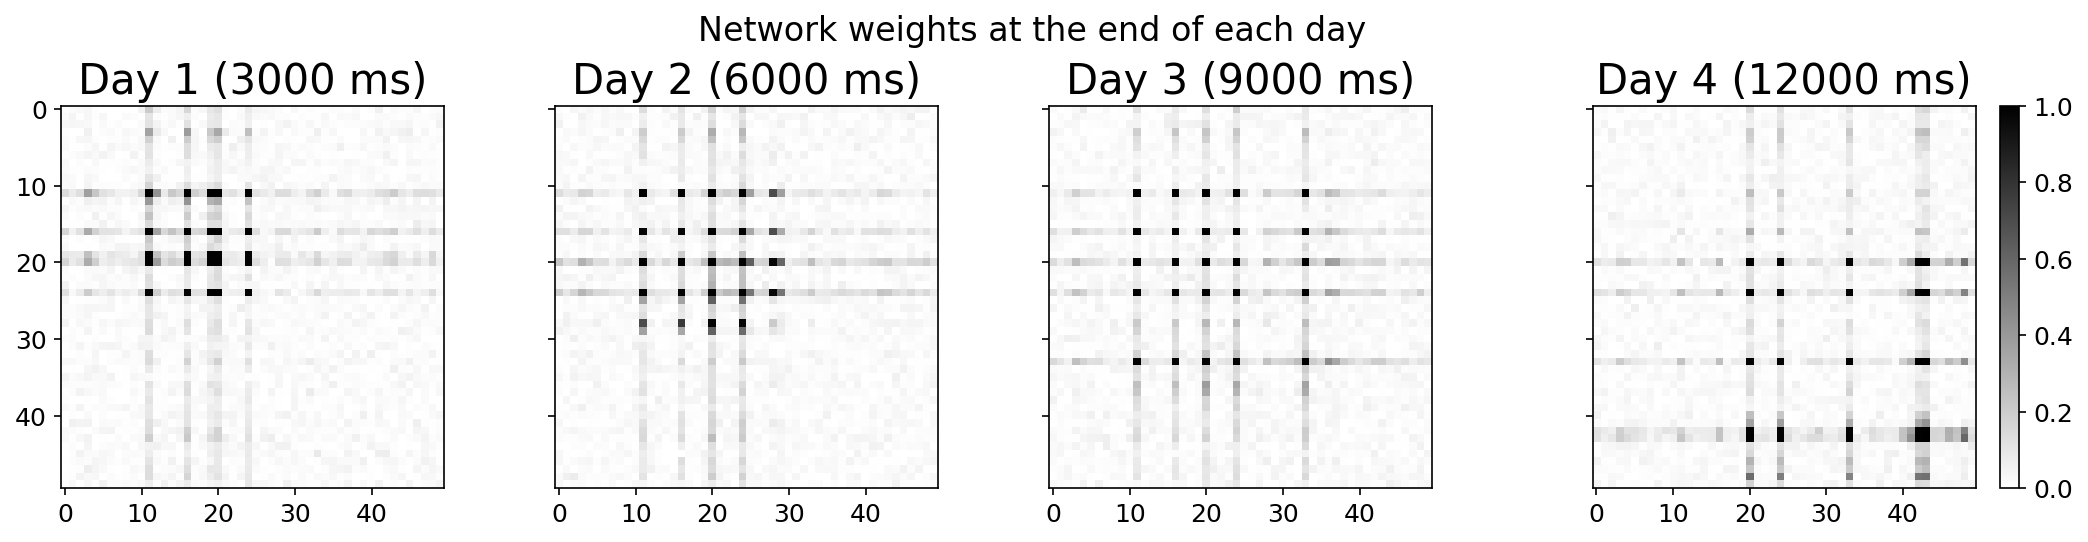

In [27]:
%matplotlib inline
fig, ax = plt.subplots(1, Nevent, figsize=(Nevent * 3.5, 3.5), sharey=True, layout='constrained')
fig.suptitle('Network weights at the end of each day', fontsize=16)

# ax.set_ylabel('Firing rate (a.u)')
# ax.set_xlabel('Time (ms)')
# ax.set_xlim(0, nstep)

if Nevent == 1:
        ax = [ax]
for i, ax in enumerate(ax):
        ax.set_title('Day ' + str(i+1) + ' (' + str(day_timesteps[i+1]) + ' ms)')
        im = ax.imshow(y[index[1][:],day_timesteps[i+1]].reshape((N,N)), vmin = 0, vmax = 1, cmap= 'binary')

cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05)
plt.show()

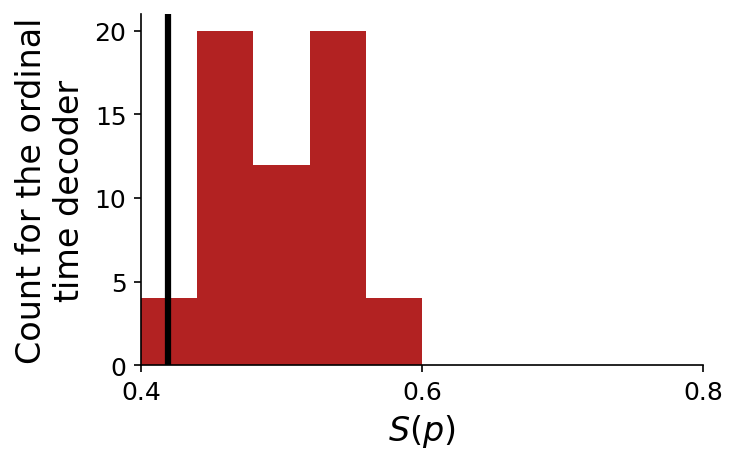

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

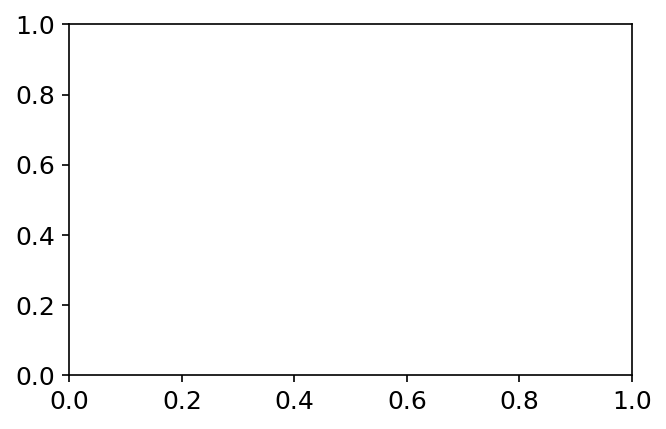

In [105]:
# You must provide a correlation function like:
# def correlation(a, b): ...

# Suppose you have V at a single E:
res = ordinal_time_decoder(V_list, correlation_fn=correlation)
plot_panel_e_pooled_Sp_distribution(res, show_true="mean")
plot_panel_e_overlay_seeds(res)